In [2]:
using Revise

In [3]:
using Distributed
procs_to_use = 20

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@everywhere @consts begin
    λ = 606e-9
    Γ = 2π * 8.3e6
    m = @with_unit 59 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **



In [339]:
@everywhere begin
    
    # saturation intensity
    Isat = π*h*c*Γ/(3λ^3) / 10
    
    # saturation parameter
    I = 5.8 # mW/cm^2, for each beam
    s = I / Isat
    
    s1 = 3s
    s2 = 0s
    s3 = 0s
    s4 = 3s
    s5 = 0s
    
    detuning = 35.0
    δ1 = +0.0
    δ2 = +0.0
    δ3 = -1.0
    δ4 = +1.0
    δ5 = +0.0
    
end
;

In [385]:
@everywhere sim_params = MutableNamedTuple(
    
    pol_imbalance = 0.0,
    s_imbalance = (0., 0., 0.),
    retro_loss = 0.,
    off_center = (0, 0, 0, 0, 0, 0) .* 1e-3,
    pointing_error = (0, 0, 0, 0, 0, 0),

    B_gradient = -50.0,
    B_ramp_time = 1e-6,
    B_offset = (0., 0., 0.),
    
    s_ramp_time = 1e-6,
    s_ramp_to = 1.0,

    s1 = s1,
    s2 = s2,
    s3 = s3,
    s4 = s4,
    s5 = s5,
    Δ1 = detuning + δ1,
    Δ2 = detuning + δ2,
    Δ3 = detuning + δ3,
    Δ4 = detuning + δ4,
    Δ5 = detuning + δ5,
    pol1_x = [1,0,0],
    pol2_x = [0,0,1],
    pol3_x = [1,0,0],
    pol4_x = [0,0,1],
    pol5_x = [1,0,0],
    
    dt = 1e-2,
    photon_budget=Inf

)
;

### Calculate transition dipole moments

In [386]:
@everywhere begin
    include("define_CaF_states.jl")
    X_states, A_states = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)

    states[14].E += 4.8e6
    states[15].E += 4.8e6
    states[16].E += 4.8e6
end
;

### Define lasers

In [387]:
@everywhere begin
    include("define_lasers.jl")
    # include("define_lasers_extra.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.s5,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.Δ5,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.pol5_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
end
;

In [388]:
# TODO:
# Try another frequency component that has two-photon detuning red of both J=3/2 hyperfine components
# Try moving the extra frequency components to the J=1/2 state
## (1/5/24) NOTE that the polarization of laser 4 was set to be the same as laser 3 no matter what when previously trying this 

# TODO experimentally:
# Increase overall intensity to get higher scattering rate, then reoptimize relative intensities
# Power scan (100) - and other repumpers???

### Define Zeeman Hamiltonian

In [389]:
@everywhere include("define_Zeeman_Hamiltonian.jl")
;

### Run simulation

In [390]:
@everywhere function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time / (1/Γ)
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    # exponential ramp
    # τ_bfield = p.sim_params.B_ramp_time / (1/Γ)
    # scalar = (exp(t/τ_bfield) - 1) / (exp(1) - 1)
    # scalar = min(scalar, 1.0)
    
    gradient_x = -scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [391]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat
)
;

In [392]:
@everywhere begin
    t_start = 0.0
    t_end   = 1e-4
    t_span  = (t_start, t_end) ./ (1/Γ)

    n_states = length(states)
    n_excited = 4

    particle = Particle()
    particle.r = (0, 0, 0) ./ (1/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0

    diffusion_constant = 0.0
end

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

# p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H, diffusion_constant=diffusion_constant)
# prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)
# cb = ContinuousCallback(condition_simple, SE_collapse_pol_always!, nothing, save_positions=(false,false))
# @time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=cb, saveat=300, maxiters=80000000, progress=true, progress_steps=200000)

p = schrodinger_stochastic_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
prob = ODEProblem(ψ_stochastic_diffusion!, p.ψ, t_span, p)
cb = ContinuousCallback(condition, SE_collapse_pol_diffusion!, nothing, save_positions=(false,false))
sol = DifferentialEquations.solve(prob, alg=Euler(), reltol=1e-3, callback=cb, saveat=4000, maxiters=50000000, dt=prob.p.dt, progress=true, progress_steps=50000)
;

ODE   0%|█                                              |  ETA: N/A
ODE  10%|█████                                          |  ETA: 0:00:10
ODE  19%|██████████                                     |  ETA: 0:00:09
ODE  29%|██████████████                                 |  ETA: 0:00:08
ODE  38%|███████████████████                            |  ETA: 0:00:07
ODE  48%|███████████████████████                        |  ETA: 0:00:06
ODE  58%|████████████████████████████                   |  ETA: 0:00:05
ODE  67%|████████████████████████████████               |  ETA: 0:00:04
ODE  77%|█████████████████████████████████████          |  ETA: 0:00:02
ODE  86%|█████████████████████████████████████████      |  ETA: 0:00:01
ODE  96%|██████████████████████████████████████████████ |  ETA: 0:00:00
ODE 100%|███████████████████████████████████████████████| Time: 0:00:10


In [393]:
(prob.p.sum_diffusion_x, prob.p.sum_diffusion_y, prob.p.sum_diffusion_z)

(216.35638663381653, 63.1604943268951, 374.4310509762589)

In [394]:
x(ψ) = real(ψ[21]) * (1/k) * 1e3
y(ψ) = real(ψ[22]) * (1/k) * 1e3
z(ψ) = real(ψ[23]) * (1/k) * 1e3
vx(ψ) = real(ψ[24]) * (Γ/k)
vy(ψ) = real(ψ[25]) * (Γ/k)
vz(ψ) = real(ψ[26]) * (Γ/k)

T_1D(v) = m*v^2 / kB
;

In [395]:
plot_us = sol.u
plot_ts = sol.t
x_trajectories = [real(u[n_states + n_excited + 1]) for u in plot_us]./k*1e3
y_trajectories = [real(u[n_states + n_excited + 2]) for u in plot_us]./k*1e3
z_trajectories = [real(u[n_states + n_excited + 3]) for u in plot_us]./k*1e3
x_velocities = [real(u[n_states + n_excited + 4]) for u in plot_us] .* (Γ/k)
y_velocities = [real(u[n_states + n_excited + 5]) for u in plot_us] .* (Γ/k)
z_velocities = [real(u[n_states + n_excited + 6]) for u in plot_us] .* (Γ/k)
velocities = [[vx,vy,vz] for (vx,vy,vz) ∈ zip(x_velocities, y_velocities, z_velocities)]

excited_population = real.([sum(conj(u[i]) * u[i] for i ∈ 13:16) for u in plot_us])
;

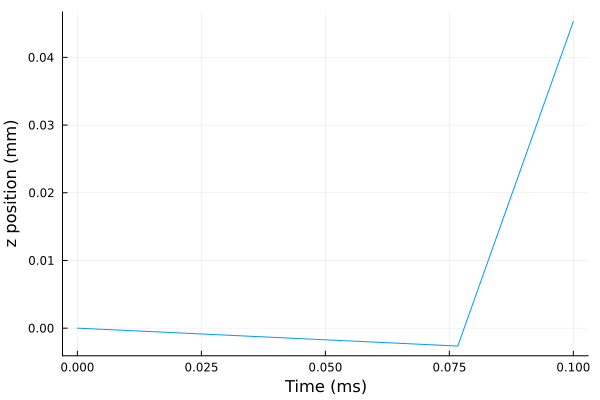

In [401]:
plot(sol.t .* (1e3/Γ), z_trajectories,
    legend=nothing,
    xlabel="Time (ms)",
    ylabel="z position (mm)"
)

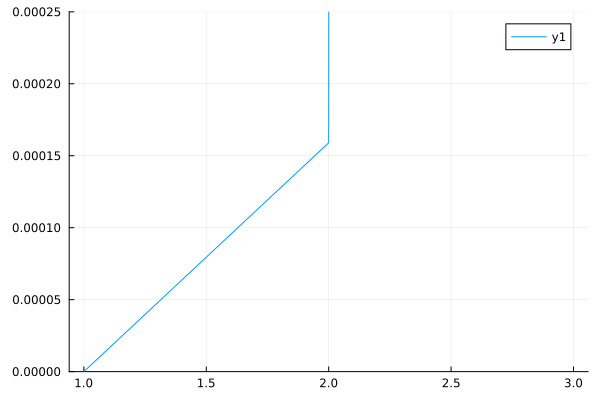

In [402]:
plot( T_1D.(vx.(sol.u)) , ylim=(0,0.00025))

In [403]:
rms_indices = floor(Int, length(sol.u)/2):length(sol.u)
vx_rms = sqrt( mean(vz.(sol.u[rms_indices]).^2) )
T_1D(vx_rms) * 1e6

174067.91974804798

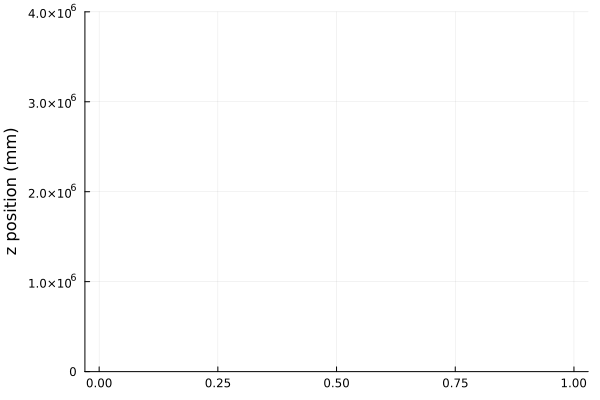

In [404]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

plot(moving_average(Γ * excited_population, 10),
    legend=nothing,
    ylabel="z position (mm)",
    ylim=(0,4e6)
)

In [405]:
prob.p.n_scatters / t_end

330000.0

### Run simulation for multiple particles in parallel

In [406]:
@everywhere function prob_func(prob, i, repeat)
    
    sim_params = prob.p.sim_params
    
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.s5,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.Δ5,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.pol5_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )

    # Define initial conditions for the molecule
    cloud_size = @with_unit 0.2 "mm"
    init_T = @with_unit 100 "μK"
    
    σ_v = sqrt(kB * init_T / m)
    
    particle = Particle()
    particle.r = (rand(Normal(0e-3, cloud_size)), rand(Normal(0e-3, cloud_size)), rand(Normal(0e-3, cloud_size))) ./ (1/k)
    particle.v = (rand(Normal(0e-3, σ_v)), rand(Normal(0e-3, σ_v)), rand(Normal(0e-3, σ_v))) ./ (Γ/k)
    
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0

#     p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; 
#         sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H, diffusion_constant=diffusion_constant)
#     callback = ContinuousCallback(condition_simple, SE_collapse_pol_always!, nothing, save_positions=(false,false))
#     prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p, callback=callback, reltol=1e-3, saveat=1000, maxiters=80000000)
    
    p = schrodinger_stochastic_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; 
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    callback = ContinuousCallback(condition, SE_collapse_pol_diffusion!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_diffusion!, p.ψ, t_span, p, callback=callback, reltol=1e-3, saveat=1000, maxiters=80000000)
    
    return prob
end
;

In [407]:
@everywhere times = 1:floor(t_span[2] / 1000)
;

In [408]:
n_molecules = 20

ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, Euler(), EnsembleDistributed(); trajectories=n_molecules, dt=prob.p.dt)
;

      From worker 16:	┌ Warning: Instability detected. Aborting
      From worker 16:	└ @ SciMLBase C:\Users\Christian\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
 29.110852 seconds (2.10 M allocations: 124.004 MiB, 0.26% gc time, 21.44% compilation time)


In [409]:
averaged_diffusion(ensemble_sol) = (
    mean(ensemble_sol[i].prob.p.sum_diffusion_x / ensemble_sol[i].prob.p.n_scatters for i ∈ 1:length(ensemble_sol) if ensemble_sol[i].t[end] == ensemble_sol[i].prob.tspan[2]),
    mean(ensemble_sol[i].prob.p.sum_diffusion_y / ensemble_sol[i].prob.p.n_scatters for i ∈ 1:length(ensemble_sol) if ensemble_sol[i].t[end] == ensemble_sol[i].prob.tspan[2]),
    mean(ensemble_sol[i].prob.p.sum_diffusion_z / ensemble_sol[i].prob.p.n_scatters for i ∈ 1:length(ensemble_sol) if ensemble_sol[i].t[end] == ensemble_sol[i].prob.tspan[2])
    );
sqrt.(sum(averaged_diffusion(ensemble_sol).^2)) / 3

0.051002379819660805

In [410]:
ensemble_sol[5].prob.p.sum_diffusion_x

2.7183926209369007

In [411]:
ensemble_sol[6].t[end]

5215.043804959057

In [376]:
x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
y_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
x_velocities = Array{Vector{Float64}}(fill([],n_molecules))
y_velocities = Array{Vector{Float64}}(fill([],n_molecules))
z_velocities = Array{Vector{Float64}}(fill([],n_molecules))
photons_scattered = zeros(n_molecules)

excited_populations = Array{Vector{Float64}}(fill([],n_molecules))

times = Array{Vector{Float64}}(fill([],n_molecules))

for i ∈ 1:n_molecules
    sol_u = ensemble_sol[i].u
    sol_t = ensemble_sol[i].t
    
    x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u] ./ k*1e3]
    y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u] ./ k*1e3]
    z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u] ./ k*1e3]
    
    x_velocities[i] = [x_velocities[i]; [real(u[n_states + n_excited + 4]) for u in sol_u] ./ (k/Γ)]
    y_velocities[i] = [y_velocities[i]; [real(u[n_states + n_excited + 5]) for u in sol_u] ./ (k/Γ)]
    z_velocities[i] = [z_velocities[i]; [real(u[n_states + n_excited + 6]) for u in sol_u] ./ (k/Γ)]
    
    photons_scattered[i] = ensemble_sol[i].prob.p.n_scatters
    
    excited_population = real.([sum(conj(u[i]) * u[i] for i ∈ 13:16) for u in sol_u])
    
    excited_populations[i] = excited_population
    
    times[i] = sol_t .* (1/Γ)
end

trajectories = [
    [[x[1],x[2],x[3]] for x ∈ zip(x_trajectories[i], y_trajectories[i], z_trajectories[i])] 
    for i ∈ 1:n_molecules
    ]
;

In [377]:
function survived(i, t_end, times)
    return t_end ≈ times[i][end]
end

survived_molecules = [i for i ∈ 1:n_molecules if survived(i, t_end, times)]

survived_times = times[survived_molecules]

survived_x_trajectories = x_trajectories[survived_molecules]
survived_y_trajectories = y_trajectories[survived_molecules]
survived_z_trajectories = z_trajectories[survived_molecules]

survived_x_velocities = x_velocities[survived_molecules]
survived_y_velocities = y_velocities[survived_molecules]
survived_z_velocities = z_velocities[survived_molecules]
;

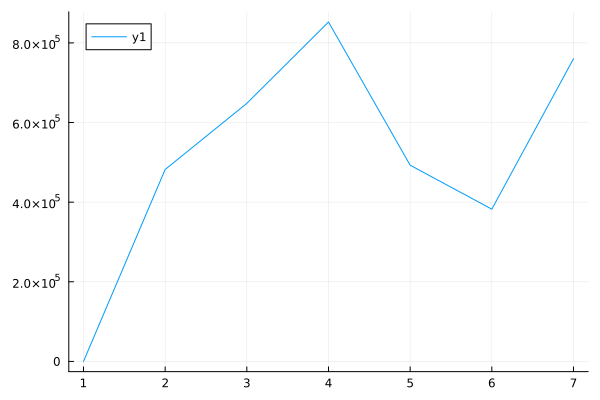

In [378]:
Γ .* mean(excited_populations[i] for i ∈ survived_molecules) |> plot

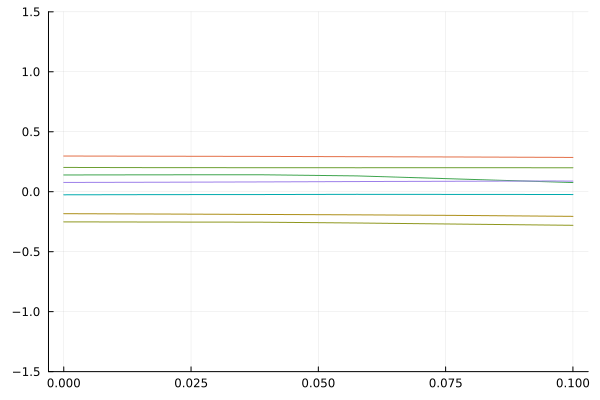

In [380]:
lim = 1.5
plot()
for i ∈ 1:n_molecules
    plot!(times[i] .* 1e3, z_trajectories[i], legend=nothing, ylim=(-lim, lim))
end
plot!()

In [334]:
function cloud_size(time, times, x_trajectories, y_trajectories, z_trajectories)
    xs = []
    ys = []
    zs = []
    for i ∈ eachindex(times)
        time_idx = searchsortedfirst(times[i], time)
        if length(times[i]) > time_idx
            push!(xs, x_trajectories[i][time_idx])
            push!(ys, y_trajectories[i][time_idx])
            push!(zs, z_trajectories[i][time_idx])
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -0.4:0.01:0.4)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [0.5, 0., 5])
    σ, x0, A = v_fit.param
    
    histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return σ
end
;

3-element Vector{Float64}:
  0.1486685453003514
 -0.055536360110051
  2.3729917008838077

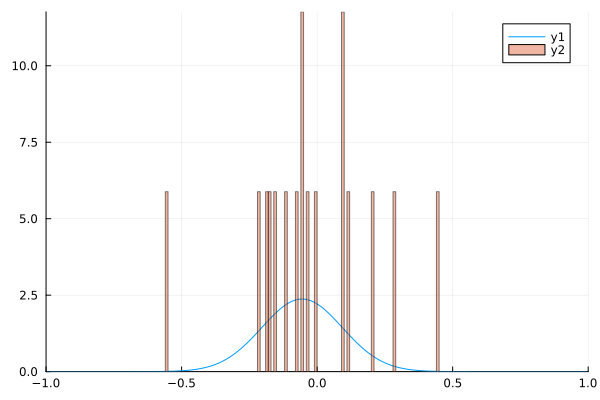

In [335]:
xs = [x_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]
ys = [y_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]
zs = [z_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]

hist_data = fit(Histogram, zs, -1.0:0.01:1.0)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs, bins=hist_data.edges, xlim=(-1.0, 1.0), alpha=0.5, normalize=true)

In [3611]:
plot_ts = 0:0.1e-3:4.9e-3
cloud_sizes = [cloud_size(t, 
        times[survived_molecules], 
        x_trajectories[survived_molecules],
        y_trajectories[survived_molecules],
        z_trajectories[survived_molecules])
    for t ∈ plot_ts]
;

In [3612]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_x_trajectories]) for i ∈ eachindex(x_trajectories[survived_molecules][1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_y_trajectories]) for i ∈ eachindex(y_trajectories[survived_molecules][1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_z_trajectories]) for i ∈ eachindex(z_trajectories[survived_molecules][1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

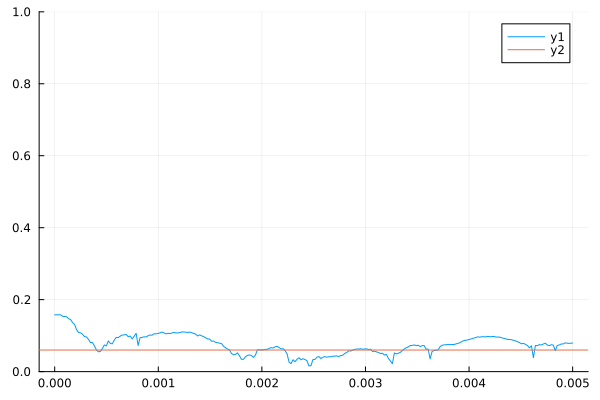

In [3613]:
plot(survived_times[1], cloud_sizes_fitted, ylim=(0,1.0))
hline!([0.06])

In [3614]:
cloud_sizes_fitted

262-element Vector{Float64}:
 0.15775601874202924
 0.15789361751196812
 0.15788745524509126
 0.15789594944022362
 0.15363593163094597
 0.15306305405992932
 0.15234366295793664
 0.14722389064730956
 0.1446081133336234
 0.13638756942545213
 0.1311576781076434
 0.11681573061636039
 0.10869010330633071
 ⋮
 0.07481344739545596
 0.07370679983097868
 0.05818248135187155
 0.07264132710231579
 0.07396999070323276
 0.07678611948606827
 0.0768076676426764
 0.0798602921896487
 0.07901599183226943
 0.07848241737503546
 0.07905464289298653
 0.07931367156726003

2-element Vector{Float64}:
 1.0298913422807434
 0.00020455744325588633

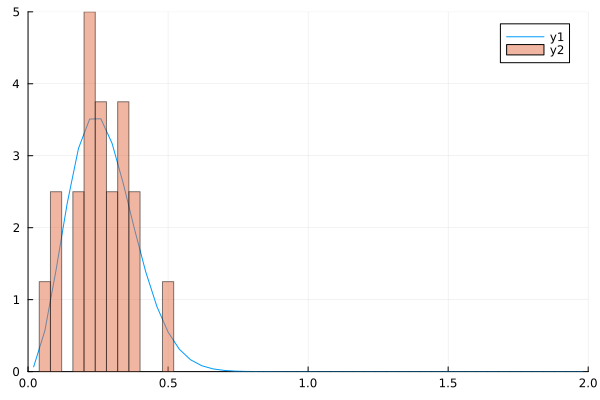

In [3605]:
velocities = [sqrt.(x_velocities[i].^2 .+ y_velocities[i].^2 .+ z_velocities[i].^2) for i ∈ survived_molecules];

function maxwell_boltzmann(v, p)
    A, T = p
    return A * ((m/(2π*kB*T))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*T)))
end

# take velocities from t = 5 ms to t = 8 ms
vs = [[v[i] for v ∈ velocities] for i ∈ 203:203]
vs = vec(hcat(vs...))

hist_data = fit(Histogram, vs, 0.0:0.04:2.0)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
A, T = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs, bins=hist_data.edges, xlim=(0.0, 2.0), alpha=0.5, normalize=true)

In [3606]:
T * 1e6

204.55744325588634

In [3607]:
function fit_temperature(vs)

    hist_data = fit(Histogram, vs, 0.0:0.04:2.0)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
    A, T = v_fit.param
    
    # histogram!(vs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return T
end
;

In [3608]:
fit_temperature([v[end] for v ∈ velocities]) * 1e6

227.02591273268484

### Scan intensity

In [197]:
function update_function_intensity(sim_params, intensity)
    
    # saturation intensity
    Isat = π*h*c*Γ/(3λ^3)/10
    
    # saturation parameter
    P = intensity * 13.1 # 13 mW/1 V
    I = 2P / (π * 0.4^2) # 8 mm 1/e^2 diameter beams
    s = I / Isat
    
    s1 = s * 3.7 / (3.7+2.8+3.5)
    s2 = s * 2.8 / (3.7+2.8+3.5)
    s3 = s * 3.5 / (3.7+2.8+3.5)
    
    sim_params.s1 = s1
    sim_params.s2 = s2
    sim_params.s3 = s3
    
    return nothing
end
;

In [198]:
intensities = [0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1] .* (0.25/0.7)

n_molecules = 40

sols = []
for intensity ∈ intensities

    update_function_intensity(prob.p.sim_params, intensity)
    
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    @time ensemble_sol = solve(ensemble_prob, Tsit5(), EnsembleDistributed(); trajectories=n_molecules)
    
    push!(sols, ensemble_sol)
end
;

 58.354290 seconds (980.90 k allocations: 39.776 MiB, 0.03% gc time)
 69.337222 seconds (982.08 k allocations: 39.846 MiB, 0.04% gc time)
 71.448136 seconds (982.32 k allocations: 39.860 MiB, 0.04% gc time)
 75.639169 seconds (982.20 k allocations: 39.849 MiB, 0.02% gc time)
 78.970403 seconds (982.25 k allocations: 39.850 MiB, 0.02% gc time)
 84.053643 seconds (982.41 k allocations: 39.853 MiB, 0.02% gc time)
 83.026523 seconds (981.93 k allocations: 39.837 MiB, 0.02% gc time)
 86.900456 seconds (981.87 k allocations: 39.803 MiB)
 92.998672 seconds (982.93 k allocations: 39.886 MiB, 0.02% gc time)
102.771731 seconds (982.92 k allocations: 39.868 MiB, 0.02% gc time)


In [202]:
# analyze each solution across all intensities
σs = []
Ts = []

for sol ∈ sols

    times = [sol[i].t for i ∈ 1:n_molecules] .* (1/Γ)

    survived_i = [i for i ∈ 1:n_molecules if t_end ≈ times[i][end]]

    xs = [real(sol[i].u[end][n_states + n_excited + 1]) for i ∈ survived_i] ./ k*1e3
    ys = [real(sol[i].u[end][n_states + n_excited + 2]) for i ∈ survived_i] ./ k*1e3
    zs = [real(sol[i].u[end][n_states + n_excited + 3]) for i ∈ survived_i] ./ k*1e3

    v_xs = [real(sol[i].u[end][n_states + n_excited + 4]) for i ∈ survived_i] ./ (k/Γ)
    v_ys = [real(sol[i].u[end][n_states + n_excited + 5]) for i ∈ survived_i] ./ (k/Γ)
    v_zs = [real(sol[i].u[end][n_states + n_excited + 6]) for i ∈ survived_i] ./ (k/Γ)
    
    vs = sqrt.(v_xs.^2 .+ v_ys.^2 .+ v_zs.^2)
    
    push!(σs, (cloud_size_fitted(xs) * cloud_size_fitted(ys) * cloud_size_fitted(zs))^(1/3))
    push!(Ts, fit_temperature(vs))
    
end
;

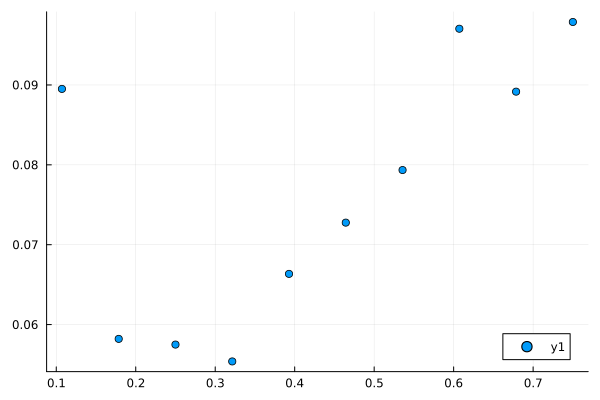

In [203]:
scatter(intensities, σs)

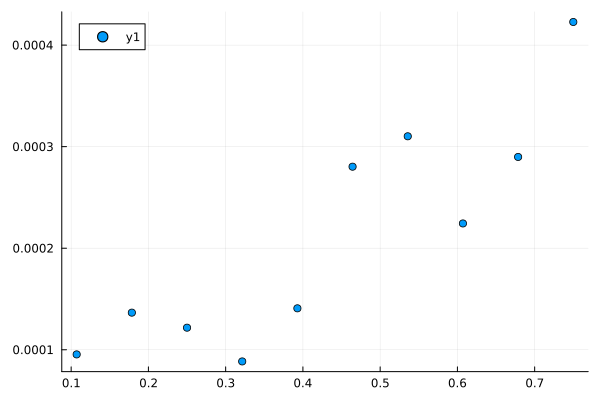

In [204]:
scatter(intensities, Ts)

### Scan detuning

In [38]:
function update_function_detuning(sim_params, detuning)
    
    # saturation intensity
    Isat = π*h*c*Γ/(3λ^3)/10
    
    # saturation parameter
    P = 0.25 * 13.1 # 13 mW/1 V
    I = 2P / (π * 0.4^2) # 8 mm 1/e^2 diameter beams
    s = I / Isat
    
    s1 = s * 3.7 / (3.7+2.8+3.5)
    s2 = s * 2.8 / (3.7+2.8+3.5)
    s3 = s * 3.5 / (3.7+2.8+3.5)
    
    sim_params.s1 = s1
    sim_params.s2 = s2
    sim_params.s3 = s3
    
    # set detuning
    δ1 = 52.75 - 53.75
    δ2 = 52.75 - 52.00
    sim_params.Δ1 = detuning
    sim_params.Δ2 = detuning + δ1
    sim_params.Δ3 = detuning + δ2
    
    return nothing
end
;

In [50]:
detunings = [1, 4, 9, 13, 16]

n_molecules = 100

detuning_sols = []
for detuning ∈ detunings

    update_function_detuning(prob.p.sim_params, detuning)
    
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    @time ensemble_sol = solve(ensemble_prob, Tsit5(), EnsembleDistributed(); trajectories=n_molecules)
    
    push!(detuning_sols, ensemble_sol)
end
;

191.920547 seconds (2.10 M allocations: 88.877 MiB, 0.03% gc time, 0.00% compilation time)
171.904563 seconds (2.10 M allocations: 88.747 MiB, 0.03% gc time)
148.221511 seconds (2.10 M allocations: 88.862 MiB, 0.03% gc time)
154.578098 seconds (2.10 M allocations: 88.733 MiB, 0.02% gc time)
161.773392 seconds (2.10 M allocations: 88.738 MiB, 0.02% gc time)


In [54]:
# analyze each solution across all intensities
σs = []
Ts = []

for sol ∈ detuning_sols[2:end]

    times = [sol[i].t for i ∈ 1:n_molecules] .* (1/Γ)

    survived_i = [i for i ∈ 1:n_molecules if t_end ≈ times[i][end]]

    xs = [real(sol[i].u[end][n_states + n_excited + 1]) for i ∈ survived_i] ./ k*1e3
    ys = [real(sol[i].u[end][n_states + n_excited + 2]) for i ∈ survived_i] ./ k*1e3
    zs = [real(sol[i].u[end][n_states + n_excited + 3]) for i ∈ survived_i] ./ k*1e3

    v_xs = [real(sol[i].u[end][n_states + n_excited + 4]) for i ∈ survived_i] ./ (k/Γ)
    v_ys = [real(sol[i].u[end][n_states + n_excited + 5]) for i ∈ survived_i] ./ (k/Γ)
    v_zs = [real(sol[i].u[end][n_states + n_excited + 6]) for i ∈ survived_i] ./ (k/Γ)
    
    vs = sqrt.(v_xs.^2 .+ v_ys.^2 .+ v_zs.^2)
    
    push!(σs, (cloud_size_fitted(xs) * cloud_size_fitted(ys) * cloud_size_fitted(zs))^(1/3))
    push!(Ts, fit_temperature(vs))
    
end
;

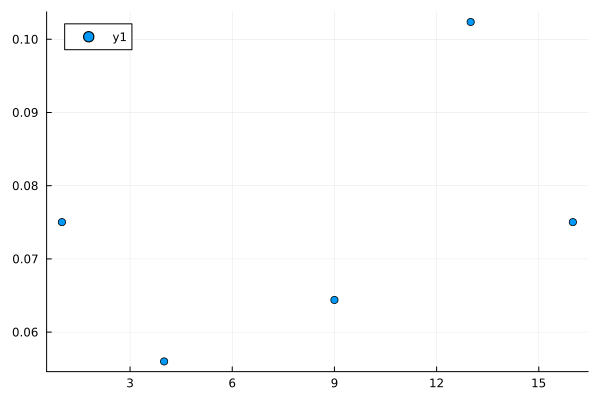

In [55]:
scatter(detunings, σs)

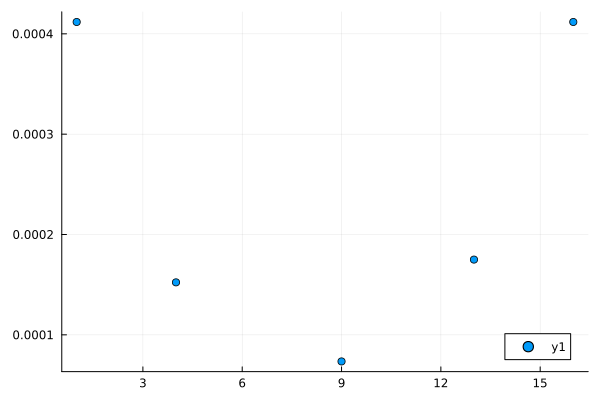

In [56]:
scatter(detunings, Ts)